
# DIGITAL IMAGE PROCESSING IN THE SPACE-FREQUENCY DOMAIN

## THE ANISOTROPIC QUALITY INDEX (AQI)    

**@author: Salvador Gabarda**

**salvador@optica.csic.es**

This notebook includes Python functions for the Anisotropic Quality Index (AQI), based on the calculation of the anisotropy of images in the space/sepace-frequency domain supported by the Wigner distribution. Details and examples of this image quality assessment measure may be found in

S. Gabarda, G. Cristóbal, "Blind image quality assessment through anisotropy", JOSA A, 2007

https://scholar.google.es/citations?user=jPzi3LEAAAAJ&hl=es&oi=ao


*Created on Dec 05 2017, reviewed Dec 27 2019*


### 1. Definition of image entropy in the spatial/spatial-frequency domain

Given a discrete random variable $X=\lbrace x_1,x_2,...,x_I \rbrace$, the Shannon entropy of such variable can be computed as 

\begin{equation}
H(X)=-\sum\limits_{i=1}^I P(x_i) \log P(x_i)       
\end{equation}        
(1) 
             

where $P(x_i)$ represents the *probability* of event $x_i$.
The Rényi entropy is given by 

\begin{equation}
R_\alpha (X)=\frac{1}{1- \alpha} \log_2 \left( \sum\limits_{i=1}^I P^\alpha(x_i) \right)
\end{equation}
(2)
                                                                                                                        

where $ \alpha $ is a real-positive number.

In this application, the Rényi entropy is calculated by means of Eq. (2) through a Wigner Distribution 

\begin{equation}
W(n,k)=2 \sum\limits_{m=- \frac{N}{2}}^{\frac{N}{2}-1} z(n+m)z^*(n-m) e^{-i2 \pi k \left(\frac{2m}{N} \right) }
\end{equation} 
(3)                                                                                                                        

In Eq. (3), $z(n)$ represents the gray values of pixel $n$ in a given image $z$. Variables $n$ and $k$ represent the spatial and spatial-frequency discrete variables respectively, and $m$ is a shifting parameter, which is also discrete.

the PWD given by Eq.(3) is normalized by applying the following normalizing rule, as a previous step to the Rényi entropy  calculation:

\begin{equation}
\widetilde{W}(n,k)=\frac{W(n,k)W^*(n,k)}{\sum\limits_{k} \left( W(n,k)W^*(n,k) \right) }=\frac{W^2(n,k)}{\sum\limits_{k}W^2(n,k)}
\end{equation} 

In this application, the general case of the Rényi entropy given by Eq. (2), is particularized by identifying $P$ with the normalized PWD in Eq.  (3) to yield

\begin{equation}
R(n)=-\frac{1}{2} \log_2 \left( \sum\limits_{k} \widetilde{W}^3 (n,k) \right)
\end{equation}
                       
Here $\alpha=3$ is normally selected for reducing the interference of cross-terms.

All the above mathematical support may be implemented by the following code. Some convolution operations have been introduced for speeding up the algorithm. 

### 2. The code

In [17]:
# import modules
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.fftpack import fft, ifft
import math
from scipy import signal

def oriented_pattern(seq_length,angle):
    """
    This function originates a pattern that is later used for the orientation of the operational pseudo-Wigner distribution
    computation window,     seq_length: sequence length in pixels,    angle: orientation in degrees.
    """
    angle = np.mod(angle,180)
    # correction to set axes in the image (x: rows, y: columns) to observer cartesian coordinates x,y
    angle = np.mod((angle+90),180)
    angle =math.radians(angle)
    pi = math.pi
    h = int((seq_length/2))
    values = np.r_[float(-h):float(h+1)]
    new_positions = np.zeros([2*h+1, 2])
    for position in range(seq_length):
        if angle >= 0 and angle < pi/4:
            new_positions[position,0] = values[position]+h
            new_positions[position,1] = values[position]*math.tan(angle)+h
        elif angle >= pi/4 and angle < pi/2:
            new_positions[position,0] = values[position]*math.tan(pi/2-angle)+h
            new_positions[position,1] = values[position]+h
        elif angle >= pi/2 and angle < 3*pi/4:
            new_positions[position,0] = values[position]*math.tan(pi/2-angle)+h
            new_positions[position,1] = values[position]+h
        elif angle >= 3*pi/4 and angle <= pi:
            new_positions[position,0] = 1*values[position]+h
            new_positions[position,1] = values[position]*math.tan(angle)+h
        new_points = np.round_(new_positions)
    return new_points.astype(int)

def image_arrangement (test_image,seq_length,angle,indices):
    """
    arrangement operation for time reduction
    """
    rows = test_image.shape[0]
    columns = test_image.shape[1]
    layers = np.zeros(((seq_length,rows,columns)))
    for k in range(seq_length):
        mask = np.zeros((seq_length,seq_length))
        mask[indices[k,0],indices[k,1]] = 1 
        layers[k,:,:] = signal.convolve2d(test_image, mask, boundary='symm', mode='same')
    return layers

def layer_product_function(layers,seq_length):
    """
    product function of the Wigner distribution
    """
    faces = layers.shape[0]
    rows =layers.shape[1]
    columns = layers.shape[2]
    layer_product = np.ones(((seq_length-1,rows,columns)))
    layers[faces-1,:,:]=layers[0,:,:]
    for i in range(faces-1):
        layer_product[i,:,:]= layers[i,:,:]*layers[faces-1-i]
    return layer_product

def layer_wigner_distribution(test_image,seq_length,angle):
    """
    Wigner distribution of test_image, seq_lengthe: odd number of pixels, e.g.: 9, angle: degrees, e.g.: 45
    """
    indices = oriented_pattern(seq_length,angle)
    layers = image_arrangement (test_image,seq_length,angle,indices)
    layer_product = layer_product_function(layers,seq_length)
    distribution = fft(layer_product, axis = 0)
    distribution = np.real(distribution)
    # set zero frequency in central position
    Head = distribution[int(seq_length/2):seq_length,:,:]
    Tail = distribution[0:int(seq_length/2),:,:]
    distribution = np.append(Head,Tail, axis = 0)
    return distribution

def renyi_entropy(distribution,order):
    """
    This function calculates the Rényi entropy of an image based on its pseudo-Wigner distribution (distribution). 
    The "order" variabe represents the exponential order of the Rényi entropy (3 is the most common value)
    """
    eps = np.finfo(float).eps
    rows = distribution.shape[1]
    columns = distribution.shape[2]
    layers = distribution.shape[0]
    squared_wl = np.ones([layers,rows,columns])
    for layer in range(layers):
        # square distribution local values
        working_layer = distribution[layer,:,:]
        squared_wl[layer,:,:] = np.multiply(working_layer,working_layer)
    squared_wd = squared_wl
    # sum squared wigner distribution along coordinate 1
    sum_sq_wd = np.sum(squared_wd, axis = 0)
    # normalize squared values
    normalized_distribution =np.zeros([layers,rows,columns])
    for layer in range(layers):
        normalized_distribution[layer,:,:] = np.divide(squared_wd[layer,:,:],sum_sq_wd+eps)
    # raise elements to the power defined by input variable "order"
    power_nor_dis = np.power(normalized_distribution,order)
    # sum pixelwise
    entropy_1 = np.sum(power_nor_dis, axis = 0)+eps
    # pixelwise entropy
    entropy_2 =np.log2(entropy_1)
    entropy =(1/(1-order))*entropy_2
    super_threshold_indices = entropy < 0
    entropy[super_threshold_indices] = 0
    entropy = np.nan_to_num(entropy)
    # normalize entropy
    entropy = entropy*(1/np.log2(layers))
    return entropy

def show_wigner_frequencies(distribution):
    """
    Starting from the pseudo-Wigner distribution (distribution) of the input test image, this function gives a visualization
    of the frequency components of such distribution and images are saved in pdf's
    """
    rows = distribution.shape[1]
    columns = distribution.shape[2]
    layers = distribution.shape[0]
    frequencies = np.zeros([layers,rows,columns])
    for layer in range(layers):
        frequency = distribution[layer,:,:]
        min_val =np.amin(frequency)
        frequency = frequency - min_val
        max_val = np.amax(frequency)
        frequency = (1/max_val)*frequency
        #plt.figure()
        frequency = np.uint8(255*frequency)
        #plt.imshow(frequency, interpolation='nearest',cmap='gray')
        #plt.imshow(frequency,cmap='gray')
        name = "wigner_distribution_" + str(layer) + ".pdf"
        msg = "Wigner distribution, frequency #" + str(layer)
        #plt.xlabel(msg)
        #plt.savefig(name)
        frequencies[layer,:,:]= frequency
    return frequencies 

def layer_image_anisotropy(test_image,image_name,seq_length,orientations,order):
    """
    This function calculates a parameter that behaves as an objective measure of the quality of the image for Gaussian blur
    and Gaussian noise. It is based on the frequency content given by the pseudo-Wigner distribution.  
    """
    entropy_val = np.zeros([orientations])
    for orientation in range(orientations):
        angle = (180/orientations)*orientation
        print( angle, " degrees distribution")
        distribution = layer_wigner_distribution(test_image,seq_length,angle)
        entropy_pixelwise = renyi_entropy(distribution,order)
        entropy = np.mean(entropy_pixelwise)
        print("entropy is %.4f" % entropy)
        entropy_val[orientation] = entropy
    anisotropy = np.var(entropy_val)
    anisotropy = math.sqrt(anisotropy)
    print("\n")
    print("The AQI (image anisotropy) is %.4f" % anisotropy)
    print("\n")
    F = open("AQI test.txt","a")
    F.write(image_name)
    F.write("\n")
    F.write("The Anisotropic Quality Index of the image is %.4f\n" % anisotropy)
    F.close()
    return anisotropy
    


### 3. The test image

By the following code we introduce the test image

In [18]:
import os
os.path
cwd = os.getcwd()
print(cwd)

/home/stefanie/IdeaProjects/MD_CompressedWavelet/notebooks


In [19]:
def input_test_image(subfolder,name):
    total_name = subfolder + name
    input_image = mpimg.imread(total_name) 
    image_dimension = len(input_image.shape)
    if image_dimension == 3:
        test_image = (1/3)*(input_image[:,:,0]+
                      input_image[:,:,1]+input_image[:,:,2])
    else:
        test_image = input_image
    
    # convert image to regular gray levels 
    test_image =np.uint8(255*test_image)
    return test_image


In [20]:
#%matplotlib inline
# input test image
image_name = 'boat.png'
subfolder = ''
test_image = input_test_image(subfolder,image_name)
# show image version to be processed 
#plt.figure(figsize =(6,6))
#plt.imshow(test_image, cmap='gray')
#plt.xlabel("Test image")
#plt.show()

### 4. The Wigner distribution

This is an example to show the pseudo-Wigner distribution as a set of images

In [21]:
# calculate Wigner distribution of test image
seq_length = 9
angle = 170.633972
distribution = layer_wigner_distribution(test_image,seq_length,angle)
# show distribution as a set of images
frequencies = show_wigner_frequencies(distribution)


### 5. Computation of image entropy

From the Wigner distribution of the test image we can calculate the image entropy. Entropy values are normalized from 0 to 1. The resulting image is saved as "Entropy.pdf" in the current directory. The pixelwise entropy is saved as "Entropy.npy".


In [22]:
# show entropy as image
#%matplotlib inline
order = 3 # this is a commom value
entropy = renyi_entropy(distribution,order)
entropy_global = np.mean(entropy)
print("global image entropy is %.4f" % entropy_global)


global image entropy is 0.0396


In [23]:
#plt.figure(figsize =(6,6))
entropy_im = np.uint8(255*entropy)
#plt.imshow(entropy_im,cmap='gray')
#plt.xlabel("Entropy")
np.save("Entropy",entropy)
#plt.savefig("Entropy_im.pdf")
#plt.show()

### 6. Definition of the Anisotropic Quality Index

The 1-D window used to measure entropy by this method may be oriented in any desired direction $\theta$, and the local entropy for pixel $n$ is now denoted as $R(n,\theta)$. This local pixel-wise directional entropy can be constrained to a scalar value for the whole image by averaging all the $R(n,\theta)$ values

\begin{equation}
\overline{R}(\theta)=\frac{1}{M}\sum\limits_{n}R(n,\theta)
\end{equation} 	
	                
provided that $M$ is the number of pixels in the image. The standard deviation of the expected directional entropy of the image has been defined as an Anisotropic Quality Index (AQI) and adopted as a quality assessment measure: 
\begin{equation}
AQI \equiv \sigma(\overline{R}(\theta)),
\end{equation}


From our experimental studies we have shown that the anisotropy of the image based on the above Rényi entropy measure is monotonously decreasing in presence of Gaussian noise. As more Gaussian noise is added to an original, its anisotropy decreases monotonously.  Also, our experiences have shown that as more blur is added to the original, its anisotropy also decreases monotonously. The maximum anisotropy is attained by the original ground truth image.  

### 7.1 Single example

This example shows the use of the code for calculating the AQI for a sigle image (the above test image)

In [24]:
orientations = 4
order = 3
seq_length = 9
anisotropy = layer_image_anisotropy(test_image,image_name,seq_length,orientations,order)

0.0  degrees distribution
entropy is 0.0351
45.0  degrees distribution
entropy is 0.0593
90.0  degrees distribution
entropy is 0.0452
135.0  degrees distribution
entropy is 0.0608


The AQI (image anisotropy) is 0.0106




### 7.2 Example of application of the AQI for comparing the quality of several related images

The following code runs a test over a set of images from TID2013 image database, corrupted with different amount of *Gaussian blur*, starting from the original and showing the measures in a graphic. The plot reveals how as more blur is added to the image the AQI value get smaller.

**Measures of the AQI are stored in file 'AQI test.txt'**


processing image  houses_00.png
0.0  degrees distribution
entropy is 0.0919
45.0  degrees distribution
entropy is 0.1016
90.0  degrees distribution
entropy is 0.0540
135.0  degrees distribution
entropy is 0.1156


The AQI (image anisotropy) is 0.0228


processing image  houses_01.png
0.0  degrees distribution
entropy is 0.0842
45.0  degrees distribution
entropy is 0.0929
90.0  degrees distribution
entropy is 0.0476
135.0  degrees distribution
entropy is 0.1069


The AQI (image anisotropy) is 0.0219


processing image  houses_02.png
0.0  degrees distribution
entropy is 0.0781
45.0  degrees distribution
entropy is 0.0860
90.0  degrees distribution
entropy is 0.0428
135.0  degrees distribution
entropy is 0.0999


The AQI (image anisotropy) is 0.0211


processing image  houses_03.png
0.0  degrees distribution
entropy is 0.0666
45.0  degrees distribution
entropy is 0.0728
90.0  degrees distribution
entropy is 0.0343
135.0  degrees distribution
entropy is 0.0865


The AQI (image anisotropy) 

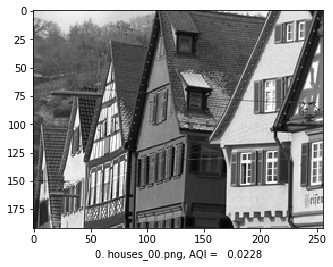

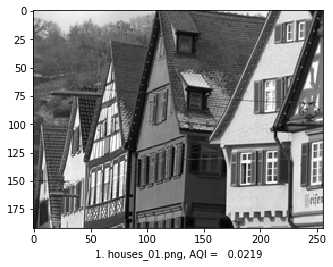

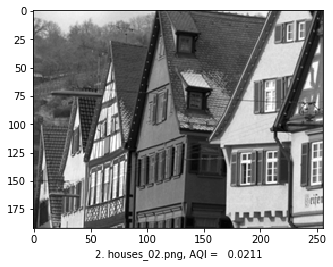

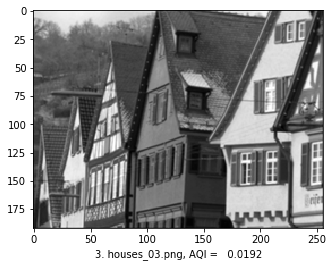

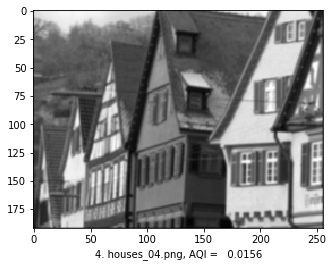

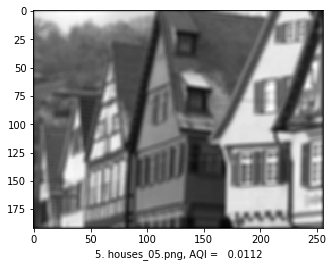

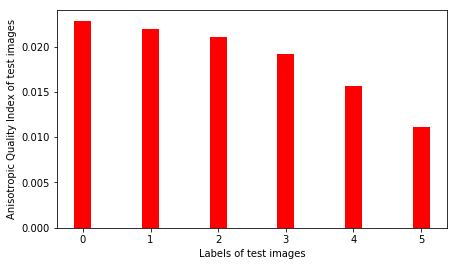

In [170]:
# initial conditions
orientations = 4
order = 3
seq_length = 9
R = 6 # number of test images
AQI =np.zeros(R)
y_pos = np.zeros(R)
subfolder = './Gaussian blur/'
for i in range(R):
    y_pos[i] = i
    # input test image
    image_name =  'houses_0' + str(i) + '.png'
    print("processing image ",image_name)
    test_image = input_test_image(subfolder,image_name)
    # process image
    anisotropy = layer_image_anisotropy(test_image,image_name,seq_length,orientations,order)
    
    AQI[i] = anisotropy
    # show processed image
    #plt.figure()
    #plt.imshow(test_image, cmap='gray')
    #label = str(i) + ". " + image_name + ", AQI = " +  "  %.4f" % anisotropy
    #plt.xlabel(label) 
    
# Test plot
#plt.figure(figsize =(7,4))
#plt.bar(y_pos, AQI,width = 1/4, align='center', alpha=1,color = "red")
#plt.ylabel("Anisotropic Quality Index of test images")
#plt.xlabel("Labels of test images")
#plt.show()
    